In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from gru2 import GRUModel
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss

(1000, 2000, 7)
(1000, 2000, 5)


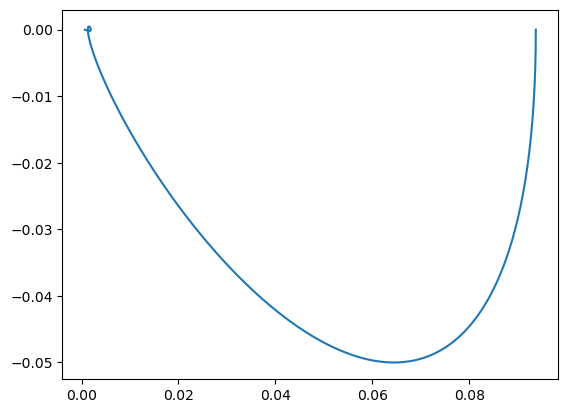

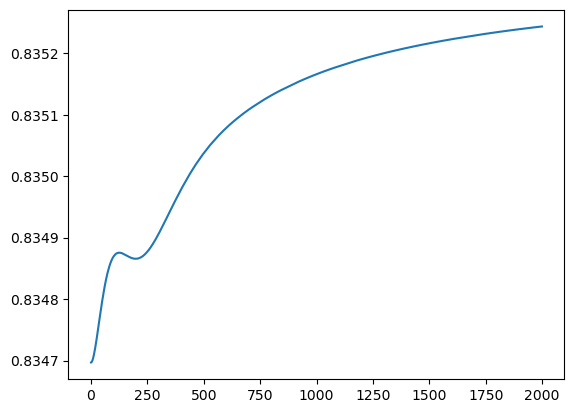

In [2]:
# Load Data

T = 20
dt = 0.01
nt = int(round(T/dt))
npoints = 1000
t1 = np.linspace(0, T, nt)
 
x = np.loadtxt("xAlpha.dat", dtype=np.float32)
x = x.reshape(
    x.shape[0], x.shape[1] // 7, 7)
y = np.loadtxt("y.dat", dtype=np.float32)
y = y.reshape(
    y.shape[0], y.shape[1] // 5, 5)

phi = x[0].transpose()[0]
p = x[0].transpose()[1]
plt.plot(phi, p)
plt.figure()
theta = y[0].transpose()
plt.plot(theta[2])

print(x.shape)
print(y.shape)

In [3]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes = 12
width = 32

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

# Normalize
x_normalizer = UnitGaussianNormalizer(x_train)
y_normalizer = UnitGaussianNormalizer(y_train)
x_train  = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)
y_train = y_normalizer.encode(y_train)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [6]:
model = GRUModel(850, 7, 5).cuda()
print(count_params(model))

2194705


In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            out = y_normalizer.decode(out)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    print(ep, t2-t1, train_mse, test_mse)

0 5.325295028975233 0.28315849900245665 0.09950708299875259
1 5.220114145893604 0.10541289034816954 0.06415138468146324
2 5.261779909022152 0.10034256660275989 0.040505225956439975
3 5.285491070942953 0.08923453850050768 0.060247385501861574
4 5.21681695105508 0.05884185470640659 0.15166550278663635
5 5.24287502001971 0.08741837446060445 0.029054762050509452
6 5.236909040948376 0.04557047254509396 0.024572224542498588
7 5.25750361289829 0.08971494245860312 0.02766023762524128
8 5.851792708970606 0.03715874490638574 0.09728083685040474
9 5.256457165116444 0.08208436618248621 0.14327446818351747
10 5.254519109148532 0.06569130449659294 0.027554379776120186
11 5.174101517070085 0.04168475746280617 0.032101132348179816
12 5.17875693901442 0.03672858646346463 0.023490088433027266
13 5.2556580738164485 0.04974604037900766 0.033800375461578366
14 5.195035569835454 0.03445117038985093 0.02673325054347515
15 5.181141890119761 0.04513946825431453 0.01964244619011879
16 5.184488440165296 0.026604

132 5.28689174586907 0.012881713050107161 0.01326635330915451
133 5.285679099150002 0.01934604075633817 0.013767489790916443
134 5.265375498915091 0.013443815977209145 0.011563180759549142
135 5.3229616531170905 0.013970219033459822 0.010982821322977543
136 5.289530788082629 0.014138064657648405 0.011855511367321015
137 5.34376933099702 0.014589424658980634 0.011491721495985985
138 5.295422426890582 0.013535709327293767 0.02305495962500572
139 5.31817603087984 0.035506935810877216 0.01350051611661911
140 5.305264282040298 0.014638908786906137 0.011522447131574154
141 5.30588490399532 0.014326794155769878 0.012003123760223389
142 5.436577329877764 0.01558504266043504 0.01912425085902214
143 5.2740257831756026 0.015059432966841592 0.011007942259311676
144 5.265469546895474 0.012217335506445832 0.011517401039600372
145 5.31335350102745 0.01431266570256816 0.017145516350865364
146 5.299720782088116 0.017545115306145616 0.012591882422566415
147 5.257858348079026 0.01450437307357788 0.012605

261 5.2904309399891645 0.009032173775550392 0.00811757454648614
262 5.3208377219270915 0.009247987551821603 0.008621136844158172
263 5.285780116915703 0.008870233916160134 0.00840261485427618
264 5.328196099027991 0.00896796914231446 0.008130156435072422
265 5.318163701798767 0.008839072369866901 0.007925579883158207
266 5.294298432068899 0.008728434507631593 0.007928205654025078
267 5.312277532881126 0.008753153329922093 0.007822559494525195
268 5.344752927077934 0.008681666550950871 0.008012183755636216
269 5.3063868950121105 0.008681610350807507 0.007955907750874758
270 5.250091783935204 0.008759984425786469 0.010014875046908855
271 5.261664432939142 0.009832108486443758 0.00847382638603449
272 5.265495979925618 0.009104105788800452 0.008026946987956762
273 5.296291021164507 0.009237503870907757 0.007919756695628166
274 5.278145052026957 0.00865526594635513 0.00777233587577939
275 5.296631349949166 0.008646430044124524 0.00841176714748144
276 5.305771563202143 0.009203511093639665 0

390 5.3292050489690155 0.007522923778742552 0.006809638720005751
391 5.351869988953695 0.007542238467269474 0.0067502808757126335
392 5.344695626059547 0.007547020736253924 0.006842489261180163
393 5.265098928939551 0.007547563904275497 0.007076978217810392
394 5.352088232059032 0.007625549969573816 0.006894565373659134
395 5.3959861940238625 0.007528187582890192 0.006755191367119551
396 5.917104235850275 0.007531974423262808 0.006739361025393009
397 5.710083655081689 0.007552361922959486 0.006858984939754009
398 5.310438197804615 0.007548585513399707 0.006759528443217278
399 5.3181285539176315 0.00749816649282972 0.007049086689949036
400 5.316462927963585 0.00751011615826024 0.006731141451746225
401 5.284566819900647 0.0075098386137849756 0.006717357598245144
402 5.384205349022523 0.007495541818853882 0.0067436154000461105
403 5.910439170897007 0.007458365967290269 0.0067269857041537765
404 5.327874600188807 0.007451378636889988 0.006753678899258375
405 5.330965782981366 0.00746305897

518 5.3218839389737695 0.007265478144917223 0.006552765611559153
519 5.330393062904477 0.0072638022092481455 0.006567394454032182
520 5.32305786293 0.007261774968355894 0.006573168933391571
521 5.297317484859377 0.007265500941624244 0.006556440703570842
522 5.282744608120993 0.007262270059436559 0.006569668650627136
523 5.303316337056458 0.007260701795005136 0.006553337164223194
524 5.273284911178052 0.007269571276588572 0.0065520753152668474
525 5.272307315841317 0.0072586999688711434 0.006583941075950861
526 5.282048152992502 0.007263590871459908 0.006552703864872456
527 5.335713231004775 0.007259525793294112 0.006545165274292231
528 5.292411956936121 0.007256984431296587 0.0065696689300239084
529 5.307681648060679 0.007255831350468927 0.006549674645066261
530 5.315551087027416 0.007258634279585547 0.006550152041018009
531 5.328345550922677 0.007254476855612464 0.006572036258876324
532 5.311642913846299 0.007260870260910855 0.006554298941046
533 5.294381445040926 0.007255531371467643

646 5.304575223010033 0.007213450440516075 0.006517525482922793
647 5.3489460970740765 0.007212364332129558 0.006511557940393686
648 5.334190787980333 0.007210530475195911 0.006513513159006834
649 5.287320718867704 0.007211237949215703 0.006519480422139168
650 5.325368005083874 0.007209589891135693 0.0065129510127007965
651 5.332621042151004 0.007210084009501669 0.006512817926704884
652 5.314762498950586 0.007209416375392013 0.00651062186807394
653 5.285910649923608 0.00721029725132717 0.006511761527508497
654 5.32093732082285 0.007209616133736239 0.006514219753444195
655 5.346764679998159 0.007209725253697899 0.006511098332703113
656 5.318426516838372 0.007209534912059705 0.006511717569082975
657 5.308485074900091 0.007208743836316797 0.006511579547077417
658 5.334371023112908 0.007208522316068411 0.006509332545101642
659 5.319202181883156 0.0072090607653889395 0.006511896569281817
660 5.315152057912201 0.007208775728940964 0.0065114031545817855
661 5.292982521932572 0.007208713030235

774 5.274296367075294 0.007201530774020486 0.0065045982599258425
775 5.276389237027615 0.007201320967740483 0.006505019310861826
776 5.275332419900224 0.007201406421760718 0.006504847668111324
777 5.27332816994749 0.007201308736370669 0.006504409946501255
778 5.277616803068668 0.007201205618265602 0.006505063362419605
779 5.2763419658876956 0.007201276315997044 0.006505062710493803
780 5.270531451096758 0.007201164339979489 0.0065048735588788984
781 5.276765275979415 0.00720117792694105 0.00650508077815175
782 5.270752670010552 0.007201227287037505 0.006503305677324533
783 5.274155335966498 0.00720103583816025 0.006504947412759065
784 5.270983188180253 0.007201299712889724 0.006504367385059595
785 5.2729410119354725 0.007201194773531623 0.006505151372402906
786 5.277917109895498 0.007201080345031288 0.006504224706441164
787 5.298297935863957 0.007201189382208718 0.006504724454134703
788 5.286536475177854 0.007201170745409198 0.006504993420094252
789 5.337144226068631 0.0072011358001165

902 5.303255768027157 0.007199664920982387 0.006503428239375353
903 5.2987420100253075 0.007199669194718202 0.006503445468842984
904 5.253055508015677 0.007199672899312443 0.006503528635948897
905 5.24494845001027 0.007199654904090696 0.006503475643694401
906 5.245088699972257 0.007199658391376336 0.0065034768544137474
907 5.248810400953516 0.007199646625667811 0.0065034800209105015
908 5.247762175975367 0.007199669029149744 0.006503466702997685
909 5.249885526951402 0.007199662137362692 0.006503541115671396
910 5.252546081086621 0.007199642124275366 0.006503516994416714
911 5.248201282927766 0.0071996603678498 0.006503527145832777
912 5.248890484916046 0.007199645125203663 0.006503540650010109
913 5.248831402044743 0.007199653931376007 0.006503594107925892
914 5.24755254201591 0.007199641917314794 0.0065035073086619375
915 5.257454121019691 0.007199653320842319 0.006503503117710352
916 5.246030390961096 0.00719963407350911 0.006503521930426359
917 5.246136375935748 0.00719962786469194

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


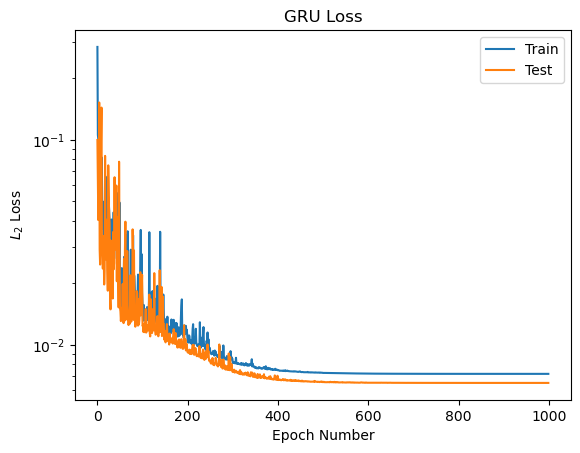

In [9]:
plt.title("GRU Loss")
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig('gru.eps')

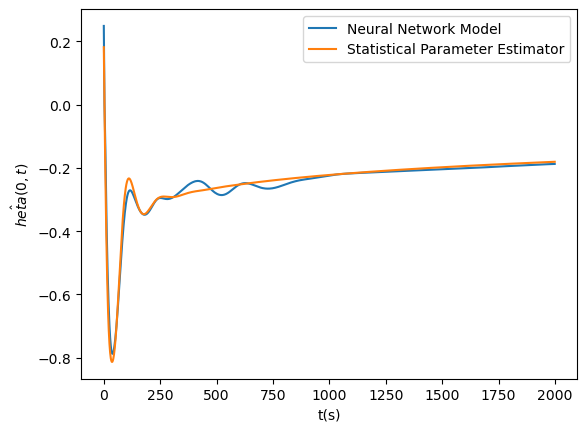

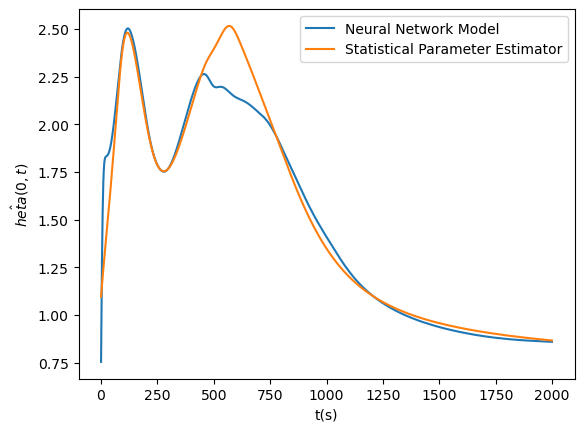

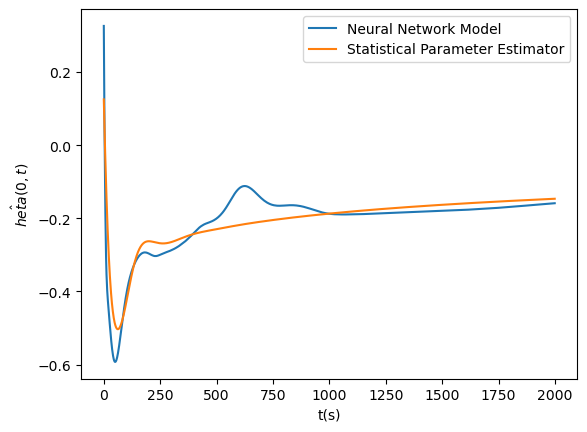

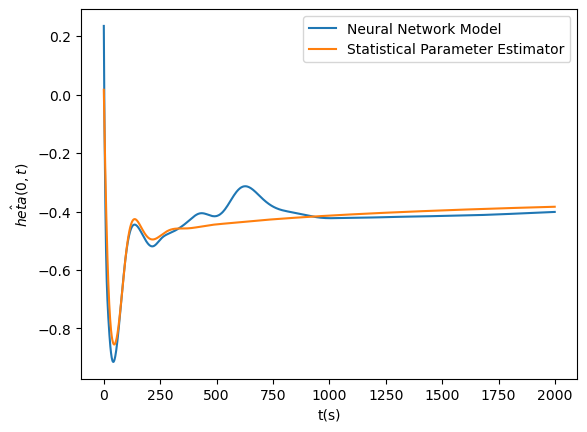

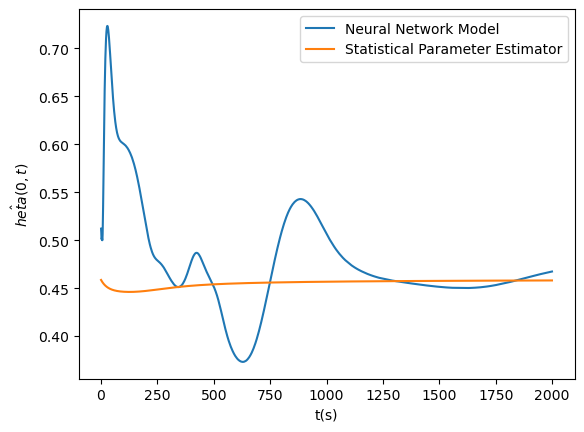

In [10]:
# Show some examples at the boundry
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        out = y_normalizer.decode(out)
        plt.figure()
        plt.plot(out[0,:, 0].detach().cpu(), label="Neural Network Model")
        plt.plot(y[0, :, 0].detach().cpu(), label="Statistical Parameter Estimator")
        plt.legend()
        plt.xlabel("t(s)")
        plt.ylabel("$\hat{\theta}(0, t)$")

In [11]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
            
        out = model(x)
        out = y_normalizer.decode(out)

        test_mse += loss(out, y).item()
print("TEST MSE For 20 Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.00650353142991662


In [12]:
torch.save(model.state_dict(), 'gruModel1')